In [68]:
# Trade War Project: Sentiment Analysis of News Articles
# Research Question: How did public sentiment correlate with actual trade volume changes?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

print("Trade War Sentiment Analysis: Connecting News Sentiment with Trade Reality")
print("=" * 80)

# 1. LOAD ALL DATASETS
print("\n1. LOADING DATASETS...")

try:
    # Load sentiment data
    sentiment_data = pd.read_csv('Data/sentiment_by_country_year.csv')
    sentiment_detail = pd.read_csv('Data/sentiment_tariff_electronics_detail.csv')
    
    # Load trade data from previous analysis
    us_china_imports_electronics = pd.read_csv('Data/Tariff/us_china_imports_electronics_clean.csv')
    us_china_exports_electronics = pd.read_csv('Data/Tariff/us_china_exports_electronics_clean.csv')
    
    print(f"✓ Sentiment by country/year: {sentiment_data.shape}")
    print(f"✓ Detailed sentiment data: {sentiment_detail.shape}")
    print(f"✓ Electronics imports: {us_china_imports_electronics.shape}")
    print(f"✓ Electronics exports: {us_china_exports_electronics.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")

Trade War Sentiment Analysis: Connecting News Sentiment with Trade Reality

1. LOADING DATASETS...
✓ Sentiment by country/year: (35, 6)
✓ Detailed sentiment data: (6848, 12)
✓ Electronics imports: (167, 11)
✓ Electronics exports: (147, 11)


In [70]:
# 2. EXPLORE SENTIMENT DATA STRUCTURE
print("\n2. SENTIMENT DATA EXPLORATION...")

print("\n--- Sentiment by Country/Year Structure ---")
print(sentiment_data.head())
print(f"\nCountries covered: {sentiment_data['country_name'].unique()}")
print(f"Years covered: {sorted(sentiment_data['year'].unique())}")
print(f"Sentiment polarity range: {sentiment_data['avg_polarity'].min():.3f} to {sentiment_data['avg_polarity'].max():.3f}")

print("\n--- Sentiment Summary Statistics ---")
print(sentiment_data.describe())

# Check for US and China data specifically
us_sentiment = sentiment_data[sentiment_data['country_name'].str.contains('United States|US|America', case=False, na=False)]
china_sentiment = sentiment_data[sentiment_data['country_name'].str.contains('China', case=False, na=False)]

print(f"\nUS sentiment records: {len(us_sentiment)}")
print(f"China sentiment records: {len(china_sentiment)}")


2. SENTIMENT DATA EXPLORATION...

--- Sentiment by Country/Year Structure ---
  country_name  year  avg_polarity  negative  neutral  positive
0    Australia  2025        0.0178         2        0         3
1      Belgium  2025       -0.2997         1        1         0
2       Canada  2025       -0.4215         1        0         0
3        China  2021        0.0000         0        1         0
4        China  2023        0.0000         0        1         0

Countries covered: ['Australia' 'Belgium' 'Canada' 'China' 'European Union' 'Germany'
 'Hong Kong' 'India' 'Indonesia' 'International' 'Japan' 'Liechtenstein'
 'Malaysia' 'Netherlands' 'Qatar' 'Singapore' 'Spain' 'Switzerland'
 'Thailand' 'United Kingdom' 'United States' 'Vietnam']
Years covered: [2020, 2021, 2022, 2023, 2024, 2025]
Sentiment polarity range: -0.625 to 0.823

--- Sentiment Summary Statistics ---
              year  avg_polarity    negative   neutral   positive
count    35.000000     35.000000   35.000000  35.00000 

In [72]:
# 3. PREPARE TRADE VOLUME DATA FOR CORRELATION
print("\n3. PREPARING TRADE VOLUME DATA...")

# Aggregate trade data by year
trade_annual = us_china_imports_electronics.groupby('year').agg({
    'value': 'sum'
}).reset_index()
trade_annual.columns = ['year', 'import_value']

# Calculate year-over-year changes
trade_annual['import_value_billions'] = trade_annual['import_value'] / 1e9
trade_annual['yoy_change'] = trade_annual['import_value'].pct_change() * 100
trade_annual['trade_volume_normalized'] = (trade_annual['import_value'] - trade_annual['import_value'].mean()) / trade_annual['import_value'].std()

print("Trade Volume by Year:")
print(trade_annual[['year', 'import_value_billions', 'yoy_change']].round(2))

# 4. ANALYSIS 1: SENTIMENT TRENDS DURING TRADE WAR


3. PREPARING TRADE VOLUME DATA...
Trade Volume by Year:
   year  import_value_billions  yoy_change
0  2018                 382.46         NaN
1  2019                 306.79      -19.79
2  2020                 280.74       -8.49
3  2021                 317.99       13.27
4  2022                 328.83        3.41
5  2023                 280.62      -14.66
6  2024                 286.96        2.26



4. ANALYSIS 1: SENTIMENT TRENDS DURING TRADE WAR


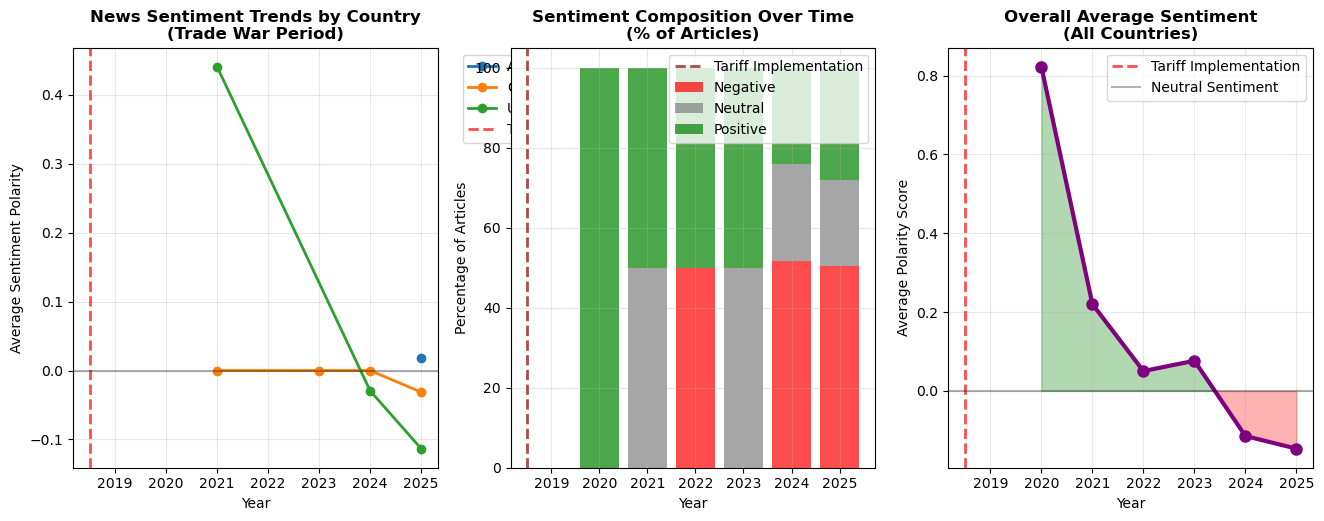

In [74]:
# 4. ANALYSIS 1: SENTIMENT TRENDS DURING TRADE WAR
print("\n4. ANALYSIS 1: SENTIMENT TRENDS DURING TRADE WAR")

# Create comprehensive sentiment analysis
plt.figure(figsize=(16, 12))

# Plot 1: Country-specific sentiment trends
plt.subplot(2, 3, 1)
countries_of_interest = ['United States', 'China', 'US', 'China', 'USA']
available_countries = []

for country in sentiment_data['country_name'].unique():
    if any(keyword.lower() in country.lower() for keyword in ['united states', 'us', 'america', 'china']):
        available_countries.append(country)
        country_data = sentiment_data[sentiment_data['country_name'] == country]
        plt.plot(country_data['year'], country_data['avg_polarity'], 
                marker='o', linewidth=2, markersize=6, label=country)

plt.axvline(x=2018.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Tariff Implementation')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('News Sentiment Trends by Country\n(Trade War Period)', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Polarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 2: Sentiment distribution over time
plt.subplot(2, 3, 2)
# Aggregate all sentiment by year
sentiment_yearly = sentiment_data.groupby('year').agg({
    'avg_polarity': 'mean',
    'negative': 'sum',
    'neutral': 'sum', 
    'positive': 'sum'
}).reset_index()

# Calculate total articles and percentages
sentiment_yearly['total_articles'] = sentiment_yearly['negative'] + sentiment_yearly['neutral'] + sentiment_yearly['positive']
sentiment_yearly['pct_negative'] = (sentiment_yearly['negative'] / sentiment_yearly['total_articles']) * 100
sentiment_yearly['pct_positive'] = (sentiment_yearly['positive'] / sentiment_yearly['total_articles']) * 100

# Stacked bar chart
plt.bar(sentiment_yearly['year'], sentiment_yearly['pct_negative'], 
        label='Negative', color='red', alpha=0.7)
plt.bar(sentiment_yearly['year'], sentiment_yearly['neutral'] / sentiment_yearly['total_articles'] * 100, 
        bottom=sentiment_yearly['pct_negative'], label='Neutral', color='gray', alpha=0.7)
plt.bar(sentiment_yearly['year'], sentiment_yearly['pct_positive'], 
        bottom=sentiment_yearly['pct_negative'] + (sentiment_yearly['neutral'] / sentiment_yearly['total_articles'] * 100), 
        label='Positive', color='green', alpha=0.7)

plt.axvline(x=2018.5, color='darkred', linestyle='--', alpha=0.7, linewidth=2, label='Tariff Implementation')
plt.title('Sentiment Composition Over Time\n(% of Articles)', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Percentage of Articles')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Average sentiment polarity trend
plt.subplot(2, 3, 3)
plt.plot(sentiment_yearly['year'], sentiment_yearly['avg_polarity'], 
         marker='o', linewidth=3, markersize=8, color='purple')
plt.axvline(x=2018.5, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Tariff Implementation')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, label='Neutral Sentiment')
plt.title('Overall Average Sentiment\n(All Countries)', fontsize=12, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Polarity Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Fill area above/below zero
x = sentiment_yearly['year']
y = sentiment_yearly['avg_polarity']
plt.fill_between(x, y, 0, where=(y >= 0), color='green', alpha=0.3, interpolate=True, label='Positive Territory')
plt.fill_between(x, y, 0, where=(y < 0), color='red', alpha=0.3, interpolate=True, label='Negative Territory')


5. ANALYSIS 2: SENTIMENT-TRADE VOLUME CORRELATION
Merged Dataset for Correlation Analysis:
   year  avg_polarity  import_value_billions  yoy_change
0  2020         0.822                280.740      -8.490
1  2021         0.220                317.988      13.268
2  2022         0.050                328.834       3.411
3  2023         0.077                280.615     -14.664
4  2024        -0.114                286.964       2.262


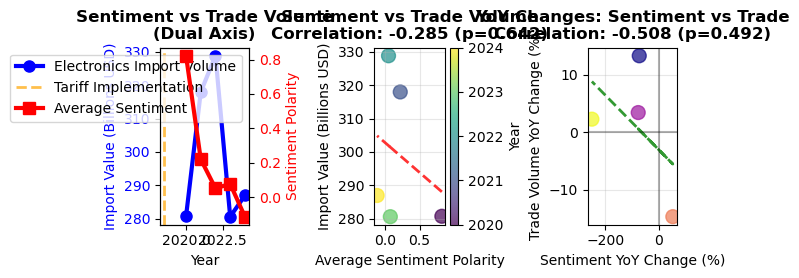

In [76]:
# 5. ANALYSIS 2: SENTIMENT VS TRADE VOLUME CORRELATION
print("\n5. ANALYSIS 2: SENTIMENT-TRADE VOLUME CORRELATION")

# Merge sentiment and trade data
merged_data = pd.merge(sentiment_yearly[['year', 'avg_polarity']], 
                      trade_annual[['year', 'import_value_billions', 'yoy_change']], 
                      on='year', how='inner')

print("Merged Dataset for Correlation Analysis:")
print(merged_data.round(3))

# Plot 4: Dual-axis sentiment vs trade volume
plt.subplot(2, 3, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot trade volume
line1 = ax1.plot(merged_data['year'], merged_data['import_value_billions'], 
                'b-o', linewidth=3, markersize=8, label='Electronics Import Volume')
ax1.set_xlabel('Year')
ax1.set_ylabel('Import Value (Billions USD)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot sentiment
line2 = ax2.plot(merged_data['year'], merged_data['avg_polarity'], 
                'r-s', linewidth=3, markersize=8, label='Average Sentiment')
ax2.set_ylabel('Sentiment Polarity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add tariff line
ax1.axvline(x=2018.5, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Tariff Implementation')

plt.title('Sentiment vs Trade Volume\n(Dual Axis)', fontsize=12, fontweight='bold')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Plot 5: Correlation scatter plot
plt.subplot(2, 3, 5)
plt.scatter(merged_data['avg_polarity'], merged_data['import_value_billions'], 
           s=100, alpha=0.7, c=merged_data['year'], cmap='viridis')

# Calculate and plot trend line
if len(merged_data) > 2:
    z = np.polyfit(merged_data['avg_polarity'], merged_data['import_value_billions'], 1)
    p = np.poly1d(z)
    plt.plot(merged_data['avg_polarity'], p(merged_data['avg_polarity']), 
             "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation
    correlation, p_value = pearsonr(merged_data['avg_polarity'], merged_data['import_value_billions'])
    plt.title(f'Sentiment vs Trade Volume\nCorrelation: {correlation:.3f} (p={p_value:.3f})', 
             fontsize=12, fontweight='bold')
else:
    plt.title('Sentiment vs Trade Volume\n(Insufficient data for correlation)', fontsize=12, fontweight='bold')

plt.xlabel('Average Sentiment Polarity')
plt.ylabel('Import Value (Billions USD)')

# Add colorbar for years
cbar = plt.colorbar()
cbar.set_label('Year')
plt.grid(True, alpha=0.3)

# Plot 6: YoY changes comparison
plt.subplot(2, 3, 6)
# Calculate sentiment YoY change
merged_data['sentiment_yoy'] = merged_data['avg_polarity'].pct_change() * 100

# Remove NaN values for correlation
clean_data = merged_data.dropna()

if len(clean_data) > 1:
    plt.scatter(clean_data['sentiment_yoy'], clean_data['yoy_change'], 
               s=100, alpha=0.7, c=clean_data['year'], cmap='plasma')
    
    # Trend line for YoY changes
    if len(clean_data) > 2:
        z_yoy = np.polyfit(clean_data['sentiment_yoy'], clean_data['yoy_change'], 1)
        p_yoy = np.poly1d(z_yoy)
        plt.plot(clean_data['sentiment_yoy'], p_yoy(clean_data['sentiment_yoy']), 
                 "g--", alpha=0.8, linewidth=2)
        
        # YoY correlation
        corr_yoy, p_val_yoy = pearsonr(clean_data['sentiment_yoy'], clean_data['yoy_change'])
        plt.title(f'YoY Changes: Sentiment vs Trade\nCorrelation: {corr_yoy:.3f} (p={p_val_yoy:.3f})', 
                 fontsize=12, fontweight='bold')
    else:
        plt.title('YoY Changes: Sentiment vs Trade\n(Insufficient data)', fontsize=12, fontweight='bold')
else:
    plt.title('YoY Changes: Sentiment vs Trade\n(No data available)', fontsize=12, fontweight='bold')

plt.xlabel('Sentiment YoY Change (%)')
plt.ylabel('Trade Volume YoY Change (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()